## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## 기초 분류 모델 만들기

* 데이터 로드
* 데이터 전처리
* 단어 벡터화(BOW, TF-IDF)
* 분류기 설정하기
* 분류기로 학습시키기
* 학습의 정확도 보기
* 테스트 데이터 예측하기
* 실제 데이터와 예측결과의 차이를 보기

## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정

In [2]:
import koreanize_matplotlib

<Axes: title={'center': '한글'}>

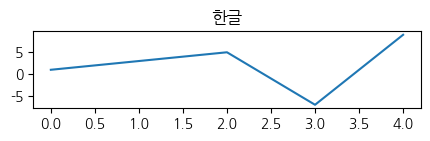

In [3]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글", figsize=(5, 1))

## 데이터 로드

In [4]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("data/klue/train_data.csv")
test = pd.read_csv("data/klue/test_data.csv")
train.shape, test.shape

((45654, 3), (9131, 2))

In [5]:
# 토픽을 불러옵니다.
topic = pd.read_csv("data/klue/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## 전처리를 위한 데이터 병합
* 학습, 예측 세트를 똑같이 전처리 해주기 위해 각각 같은 방법을 적용해 줄 수도 있지만
* 두 데이터를 병합해서 전처리를 해주고 다시 나눠주는 방법을 알아보기 위해 병합 후 나눠보겠습니다.

## concat
<img src="https://pandas.pydata.org/docs/_images/08_concat_row.svg" width="500">

In [11]:
# 전처리를 위해 데이터 병합
df = pd.concat([train, test])
df.shape

(54785, 3)


## 정답값 빈도수
* train 에서 제공하는 정답값의 빈도수

In [25]:
topic['topic']

0    IT과학
1      경제
2      사회
3    생활문화
4      세계
5     스포츠
6      정치
Name: topic, dtype: object

In [26]:
# 정답값 빈도수를 확인합니다.
topic_count = train["topic_idx"].value_counts()
topic_count = topic_count.sort_index()
topic_count.index = topic['topic']
topic_count

topic
IT과학    4824
경제      6222
사회      7362
생활문화    5933
세계      7629
스포츠     6933
정치      6751
Name: count, dtype: int64

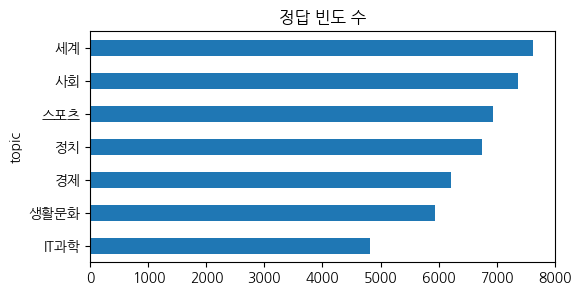

In [38]:
# 정답값 빈도수를 시각화 합니다.
topic_count.sort_values().plot(kind="barh", figsize=(6, 3), title="정답 빈도 수");

## 문자 전처리

In [39]:
# 정규표현식
import re

def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로 만듭니다.
    text = text.lower()
    return text

In [40]:
# map을 통해 전처리 일괄 적용
df["title"] = df["title"].map(preprocessing)

### 불용어 제거

In [42]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [43]:
df["title"] = df["title"].map(remove_stopwords)

## 학습, 예측 데이터셋 분리
* 전처리가 되었다면 concat 으로 합쳐주었던 데이터프레임을 다시 학습과 예측 데이터셋으로 분리합니다.

In [45]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
label_name = "topic_idx"
label_name

'topic_idx'

In [53]:
train.shape, test.shape

((45654, 3), (9131, 2))

In [52]:
# label_name 을 기준으로 학습, 예측 세트를 분리합니다.
# label_name 이 있다면 학습 세트, 없다면 예측 세트가 됩니다.
df_train = df[df[label_name].notnull()].copy()
df_test = df.loc[df[label_name].isnull(), ["index", "title"]].copy()
df_train.shape, df_test.shape

((45654, 3), (9131, 2))

In [56]:
# 기출문제의 정답을 만들어 줍니다.
# 잘 나뉘었는지 정닶 값의 빈도수를 확인해 봅니다.
y_train = df_train[label_name].astype(int)
y_train

0        4
1        4
2        4
3        4
4        4
        ..
45649    1
45650    2
45651    1
45652    2
45653    2
Name: topic_idx, Length: 45654, dtype: int64

In [ ]:
# 테스트의 정답은 모두 결측치 입니다.
# Dacon 사이트에 예측 값을 제출해야 맞고 틀린 갯수를 알 수 있습니다.
# y_test

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용 되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 출처 : [tf-idf - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/Tf-idf)

In [58]:
# TfidfVectorizer 로 벡터화 합니다.
from sklearn.feature_extraction.text import TfidfVectorizer
# fit 으로 변환할 어휘를 학습합니다.

tfidfvect = TfidfVectorizer(max_features=2000)
tfidfvect.fit(df_train["title"])

TfidfVectorizer(max_features=2000)

In [60]:
# transform
X_train = tfidfvect.transform(df_train["title"])
X_test = tfidfvect.transform(df_test["title"])
X_train, X_test

(<45654x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 127949 stored elements in Compressed Sparse Row format>,
 <9131x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 25576 stored elements in Compressed Sparse Row format>)

In [62]:
# 단어 사전 feature_names
feature_names = tfidfvect.get_feature_names_out()
feature_names

array(['afc', 'ag', 'ai', ..., '희망', '희생자', '힐러리'], dtype=object)

In [66]:
# np.sum 으로 위에서 구한 TF-IDF 값을 단어별로 더합니다. axis=0 으로 합니다. 

df_train_vocab = pd.DataFrame(X_train.toarray(), columns=feature_names)
df_train_vocab.sum()

afc      15.177806
ag       21.725468
ai      117.674345
ceo      21.679064
cj       17.911939
           ...    
흑자전환     16.867666
흥국생명     29.266299
희망       27.503375
희생자      17.099391
힐러리      56.208043
Length: 2000, dtype: float64

In [69]:
# TF-IDF 합계 값이 높은 상위 20개 어휘
df_train_vocab.sum().nlargest(20)

대통령    635.826447
신간     515.872746
게시판    359.763017
억원     352.378423
출시     336.948266
감독     277.461546
트럼프    276.234327
이란     262.322975
개발     251.091199
개최     246.356875
한국     243.032916
kt     242.074555
분기     234.710982
만에     196.365893
정부     193.406648
김정은    190.230796
올해     190.204747
코로나    189.042454
그래픽    186.746914
월드컵    185.458872
dtype: float64

<Axes: >

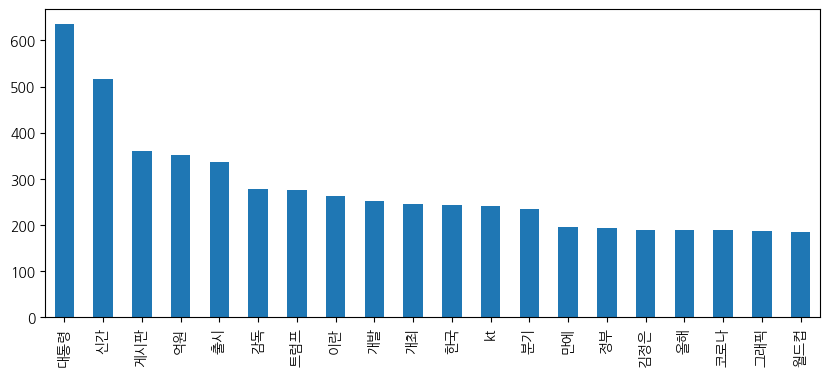

In [71]:
# 위에서 구한 빈도수를 그래프로 그립니다.

df_train_vocab.sum().nlargest(20).plot(kind="bar", figsize=(10, 4))

## 모델 학습



<img src="https://i.imgur.com/rKOYbeX.png">

전체 과정
* feature_names : 학습(훈련), 예측에 사용할 단어 사전 입니다.
* label_name : 정답값

* X_train : feature_names 에 해당되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 데이터셋 예) 시험의 기출문제

* X_test : feature_names 에 해당되는 컬럼만 test에서 가져옵니다.
    * 예측에 사용할 데이터셋 예) 실전 시험문제

* y_train : label_name 에 해당 되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 정답 값 예) 기출문제의 정답

* model : 학습, 예측에 사용할 머신러닝 알고리즘

* model.fit(X_train, y_train) : 학습(훈련), 기출문제와 정답을 가지고 학습(훈련)하는 과정과 유사합니다.

* model.predict(X_test) :  예측, 실제 시험을 보는 과정과 유사합니다. => 문제를 풀어서 정답을 구합니다.

* score
    * 시험을 봤다면 몇 문제를 맞고 틀렸는지 채점해 봅니다.
* metric
    * 점수를 채점하는 공식입니다. (예를 들어 학교에서 중간고사를 봤다면 전체 평균을 계산해 줍니다.)


### RandomForestClassifier

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Randomforests_ensemble.gif">

### DecisionTree와 Randomforest의 Parameter
* n_estimators
    * DecisionTree 는 트리를 하나만 만들기 때문에 없음
    * 결정트리의 개수, 많을 수록 성능이 좋아지나 오래걸리며 샘플의 수에 따라 트리를 만들 수 있는 개수가 제한적
* max_depth
    * 트리의 최대 깊이
* max_features	
    * 피처의 개수(int) 혹은 비율(float)
    * sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 사용
    * log : 전체 피처 중 log2(전체 피처 개수) 만큼 
* min_samples_split
    * 노드를 분할하기 위한 최소 샘플 데이터수
* min_samples_leaf
    * 리프노드가 되기 위해 필요한 최소 샘플 데이터수
* max_leaf_nodes
    * 리프노드의 최대 개수
* n_jobs
    * 사용할 CPU 코어의 수, -1로 설정 시 사용할 수 있는 모든 CPU코어를 사용
    

In [92]:
# RandomForestClassifier 를 불러옵니다.
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model

RandomForestClassifier(n_jobs=-1)

In [94]:
# n_estimators=100
# help(RandomForestClassifier)

## 교차 검증

<img src="https://i.imgur.com/x9M8zpI.png" width="600">

In [96]:
# cross_val_predict 로 교차 검증을 합니다.
from sklearn.model_selection import cross_val_predict

y_valid_pred = cross_val_predict(model, X_train, y_train, cv=3, n_jobs=-1, verbose=2)
y_valid_pred[:10]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.4s finished


array([2, 1, 4, 1, 4, 4, 4, 4, 6, 4])

### 교차 검증 정확도

In [97]:
# 교차 검증 결과 
y_valid_pred

array([2, 1, 4, ..., 2, 3, 2])

In [101]:
# 교차 검증 결과 점수를 구해봅니다.
# 모의고사를 보고 채점해 보는 과정과 유사합니다.
valid_accuracy = (y_train == y_valid_pred).mean()
valid_accuracy

0.7049765628422482

In [113]:
# df_accuracy 로 정답여부 컬럼을 만듦
df_accuracy = y_train.to_frame()
df_accuracy["valid_predict_idx"] = y_valid_pred
df_accuracy["accuracy"] = (y_train == y_valid_pred)
df_accuracy.head()

,topic_idx,valid_predict_idx,accuracy
0,4,2,False
1,4,1,False
2,4,4,True
3,4,1,False
4,4,4,True


In [109]:
pd.crosstab(df_accuracy["topic_idx"], df_accuracy["valid_predict_idx"]).style.background_gradient(axis=None)

valid_predict_idx,0,1,2,3,4,5,6
topic_idx,,,,,,,
0,3416,342,410,386,134,67,69
1,674,3974,663,437,238,117,119
2,473,578,3880,1296,440,158,537
3,215,164,565,4595,182,121,91
4,186,300,530,462,5390,172,589
5,128,101,186,348,190,5870,110
6,83,133,508,505,390,72,5060


In [119]:
# groupby 로 분류별 정확도를 구합니다.
df_group_accuracy = df_accuracy.groupby("topic_idx")["accuracy"].mean()
df_group_accuracy.index = topic["topic"]
df_group_accuracy.sort_values(ascending=False)

topic
스포츠     0.846675
생활문화    0.774482
정치      0.749519
IT과학    0.708126
세계      0.706515
경제      0.638701
사회      0.527031
Name: accuracy, dtype: float64

## 학습

In [120]:
# fit 으로 학습시킵니다.
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

<Axes: >

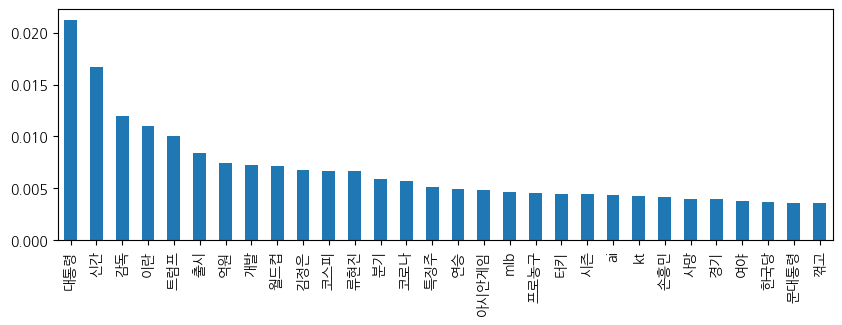

In [126]:
# 피처 중요도 구하기
fi = pd.Series(model.feature_importances_)
fi.index = feature_names
fi.nlargest(30).plot(kind="bar", figsize=(10, 3))

## 예측

In [127]:
# 실전 시험과 유사합니다. 정답 없이 문제만 넣고 풀어서 예측합니다.
# predict로 예측합니다. 
y_predict = model.predict(X_test)
y_predict[:10]

array([2, 3, 1, 2, 3, 3, 5, 3, 4, 4])

## 정답값 로드

In [128]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.
submit = pd.read_csv("data/klue/sample_submission.csv")
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [130]:
# 정답값 측정을 위해 y_test 변수에 할당
submit["topic_idx"] = y_predict
submit

,index,topic_idx
0,45654,2
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,3
9128,54782,4
9129,54783,2


In [132]:
file_name = f"data/klue/submit_{valid_accuracy:.5f}.csv"
file_name

'data/klue/submit_0.70498.csv'

In [135]:
# 파일로 저장합니다.
submit.to_csv(file_name, index=False)

In [136]:
# 잘 저장이 되었는지 확인합니다.
pd.read_csv(file_name)

,index,topic_idx
0,45654,2
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,3
9128,54782,4
9129,54783,2


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경